## import other libaries

In [1]:
import matplotlib.pyplot as plt
import numpy as np 

In [2]:
def make_polar_axis():
    ''' returns matploblib.axes object with polar projection.
    The axes are set up to display date in the form of:
        p = (r=azimuth, theta=zenith)
    '''    
    ax = plt.subplot(111,projection='polar')
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_rlim(0,90)
    ax.set_xlabel('azimuth [°]')
    ax.text(np.radians(25),105,'zenith [°]',
        rotation=0,ha='left',va='bottom')
    return ax

## basic example

In [3]:
# import pysolar, datetime
from pysolar import solar
import datetime

In [4]:
latitude = 52.37
longitude = 9.73
date = datetime.datetime.fromisoformat('2023-01-01T14:00:00+00:00')

In [5]:
# get_position()
solar.get_position(latitude, longitude, date)

C:\Users\user\.conda\envs\phy\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


(215.63104265020925, 7.480603079087738)

In [6]:
# get_azimuth()
solar.get_azimuth(latitude, longitude, date)

215.63104265020925

In [8]:
# get_altitude()
solar.get_altitude(latitude, longitude, date)

7.480603079087738

## advanced example

In [24]:
# define dates
dates = np.array([datetime.datetime.strptime(f'2020/{i} 15:00:00+0000','%Y/%j %X%z') 
         for i in range(1,356)])
dates[0:5]

array([datetime.datetime(2020, 1, 1, 15, 0, tzinfo=datetime.timezone.utc),
       datetime.datetime(2020, 1, 2, 15, 0, tzinfo=datetime.timezone.utc),
       datetime.datetime(2020, 1, 3, 15, 0, tzinfo=datetime.timezone.utc),
       datetime.datetime(2020, 1, 4, 15, 0, tzinfo=datetime.timezone.utc),
       datetime.datetime(2020, 1, 5, 15, 0, tzinfo=datetime.timezone.utc)],
      dtype=object)

In [27]:
# calculate azimuths
altitudes = [solar.get_altitude(latitude, longitude, d) for d in dates]

In [28]:
# calculate zeniths
azimuths = [solar.get_altitude(latitude, longitude, d) for d in dates]

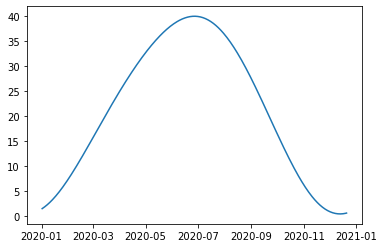

In [29]:
# show results
plt.plot(dates, azimuths)

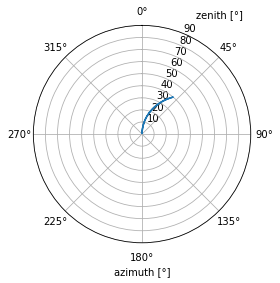

In [31]:
# use make_polar_axis()
ax = make_polar_axis()
ax.plot(np.radians(azimuths), altitudes)
plt.show()

## and more advanced usecase

In [ ]:
import pandas as pd
import time
import pathlib 
PATH_EXPORT = pathlib.Path('../results/')

In [ ]:
def calc_spa(df, lat, lon):
    df = df.copy()
    df['altitude'] = df.apply(lambda r: solar.get_altitude(lat, lon, r['time'].to_pydatetime()), axis=1)
    df['azimuth'] = df.apply(lambda r: solar.get_azimuth(lat, lon, r['time'].to_pydatetime()), axis=1)
    df['zenith'] = 90-df['altitude']
    df['doy'] = df.apply(lambda r: r.time.dayofyear, axis=1)
    return df

# PARAMETERS
filename = 'data_2019_in_hours.csv'
lat = 52.37
lon = 9.73
tz = 'UTC'

start = time.perf_counter()
# GENERATE DATASET
data = pd.DataFrame({
    'time' :pd.date_range('2019-01-01 00:00:00', '2020-01-01', freq='H', tz=tz)
})
data = calc_spa(data, lat, lon)
# data.to_csv(filename, index=False)

print(len(data), 'calculations were generated and saved in', time.perf_counter()-start, 's')

In [ ]:
data = pd.read_csv('data_2019_in_hours.csv', parse_dates=[0])
subset = data[data.zenith<90]
subset.head()

In [ ]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111,projection='polar')

# scatter all data
points = ax.scatter(np.radians(subset.azimuth), subset.zenith, c=subset.doy, s=2)
ax.figure.colorbar(points, label='day of year')

# add highest and lowest point (['2019-06-21', '2019-12-21'])
for d,d2 in [('2019-06-21','2019-06-22'), ('2019-12-21','2019-12-22')]:
    s1 = data.loc[(data['time'] >= d) 
            & (data['time'] <= d2)]
    ax.plot(np.radians(s1.azimuth), s1.zenith, label=d)

# add hour label
for hour in np.unique(subset.time.dt.hour):
    s1 = subset.loc[subset['time'].dt.hour == hour]
    pos = subset.loc[s1.zenith.idxmin()]
    ax.text(np.radians(pos['azimuth']), pos['zenith'], str(hour))
    
# adjust the layout
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_rlim(0,90)
ax.set_xlabel('azimuth [°]')
ax.text(np.radians(25),98,'zenith [°]',
        rotation=0,ha='left',va='bottom')
ax.text(np.radians(300),95,'hour (UTC)',
        rotation=0,ha='right',va='bottom')
ax.legend(loc='lower left',bbox_to_anchor=(-0.15,-0.15))
plt.tight_layout()
plt.savefig(PATH_EXPORT/'example_adv.png', dpi=300, bbox_inches='tight')
plt.show()
print(f'sun position angles for Hannover ({lat:2.1f},{lon:2.1f})\nevery hour in 2019')